In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [38]:
df = pd.read_csv('/content/drive/MyDrive/GitHub Project/PJME_hourly.csv.zip', index_col=[0], parse_dates = [0]) #自动把 index列化为 datetime

df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [40]:
df.dtypes

,0
PJME_MW,float64


<Axes: title={'center': 'PJME_MW'}, xlabel='Datetime'>

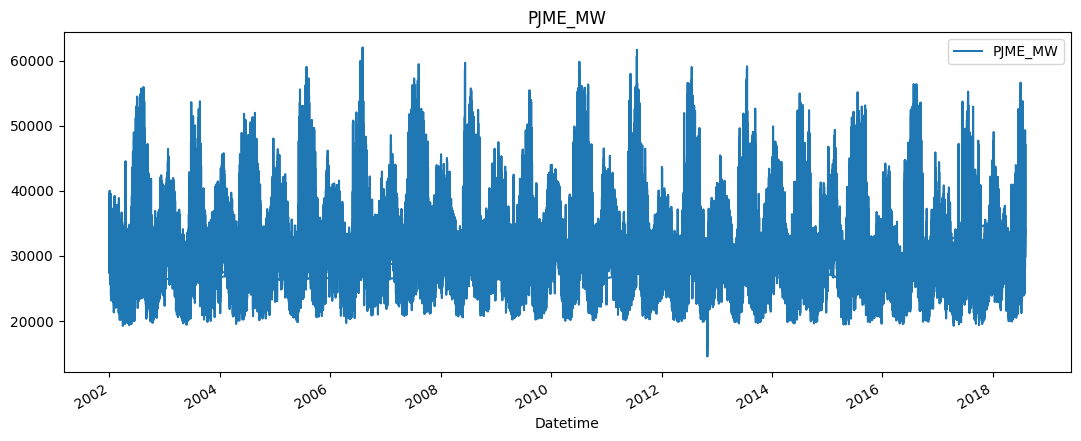

In [41]:
df.plot(figsize = (13,5), title = 'PJME_MW')

In [42]:
split_time = '01-01-2015'
df_train = df.loc[df.index <= split_time]
df_test = df.loc[df.index > split_time]

In [43]:
df_train

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0


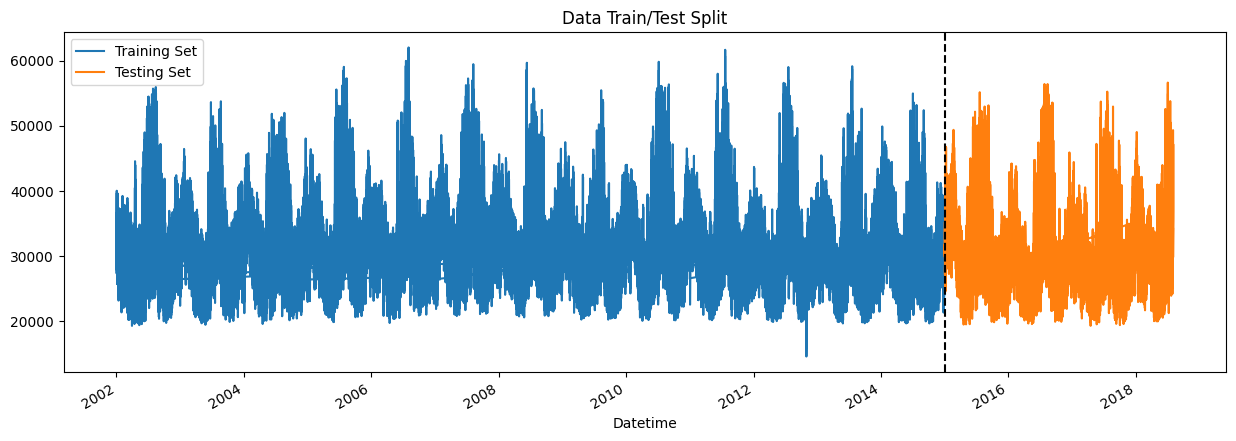

In [44]:
fig, ax = plt.subplots(figsize = (15,5))
df_train.plot(ax = ax, label = 'Training Set', title = 'Data Train/Test Split')
df_test.plot(ax = ax, label = 'Testing Set')
#ax=ax：告诉 pandas 的 plot() 函数在这个指定的 ax 坐标轴上绘制图表，而不是自动创建一个新的图表。
#这通常用于在同一个图表中绘制多个数据集，方便对比。

ax.axvline('01-01-2015', color = 'black', ls='--')
plt.legend(['Training Set', 'Testing Set'])
plt.show()


# **Create Features**

In [45]:
def create_features(df):
  df['date'] = df.index
  df['hour'] = df['date'].dt.hour
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.isocalendar().week


  return df

df = create_features(df)
df.head()



,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,5,1,4,12,2002,365,31,1


<ipython-input-46-f670e9923cc8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x=i, y='PJME_MW', palette = 'coolwarm')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a f

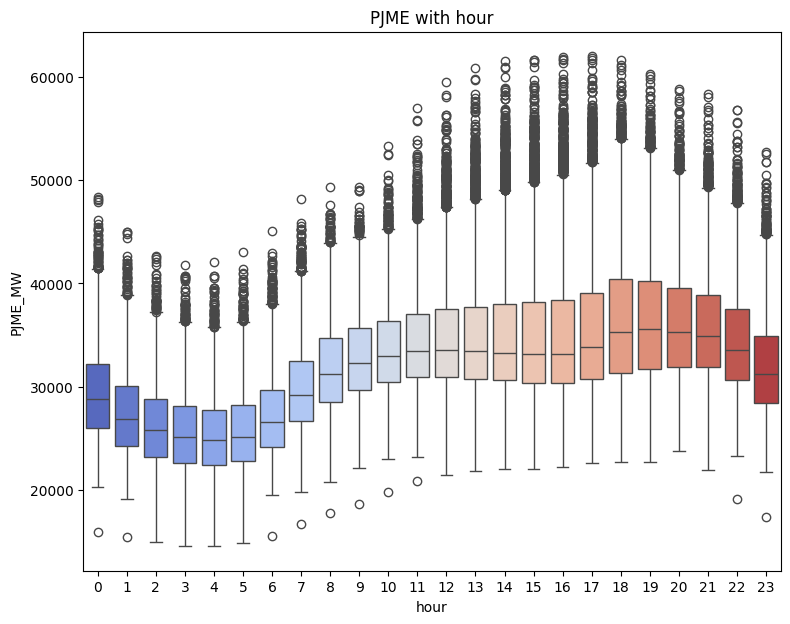

<ipython-input-46-f670e9923cc8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x=i, y='PJME_MW', palette = 'coolwarm')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a f

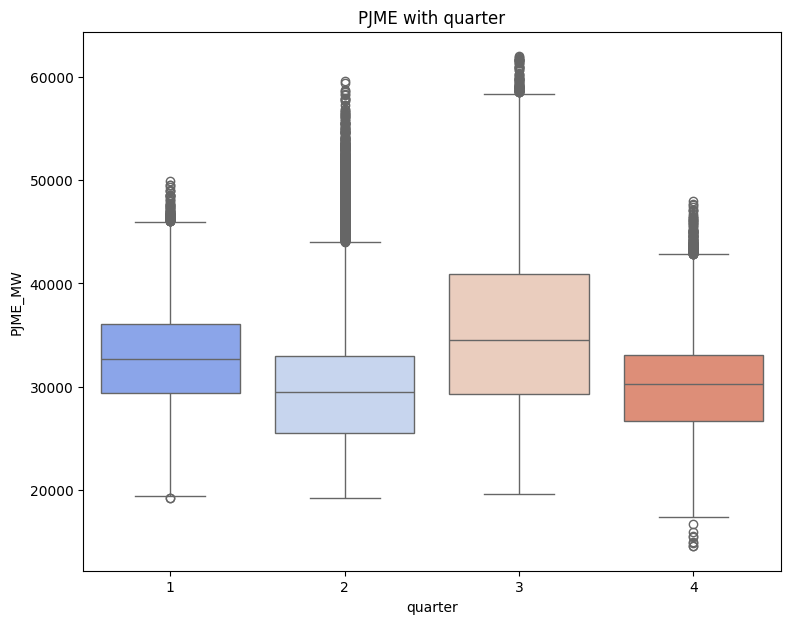

<ipython-input-46-f670e9923cc8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x=i, y='PJME_MW', palette = 'coolwarm')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a f

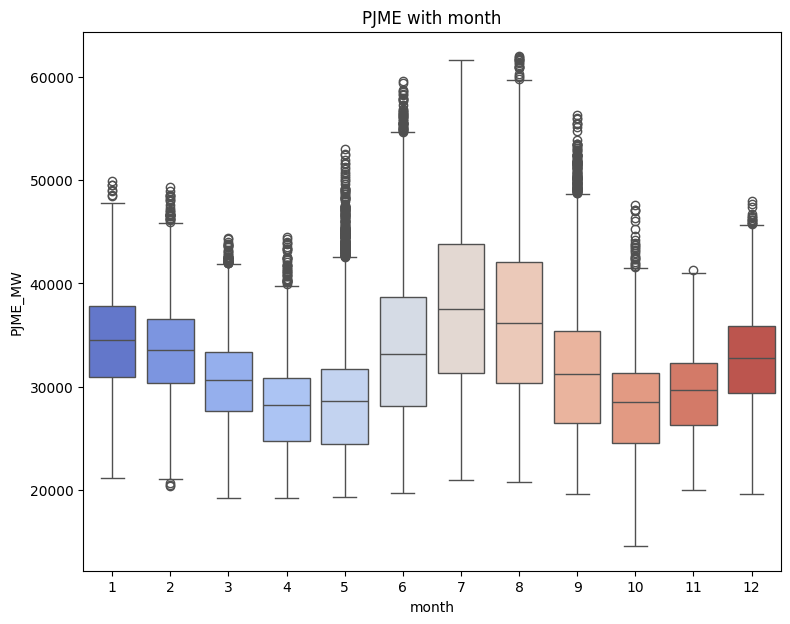

<ipython-input-46-f670e9923cc8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x=i, y='PJME_MW', palette = 'coolwarm')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a f

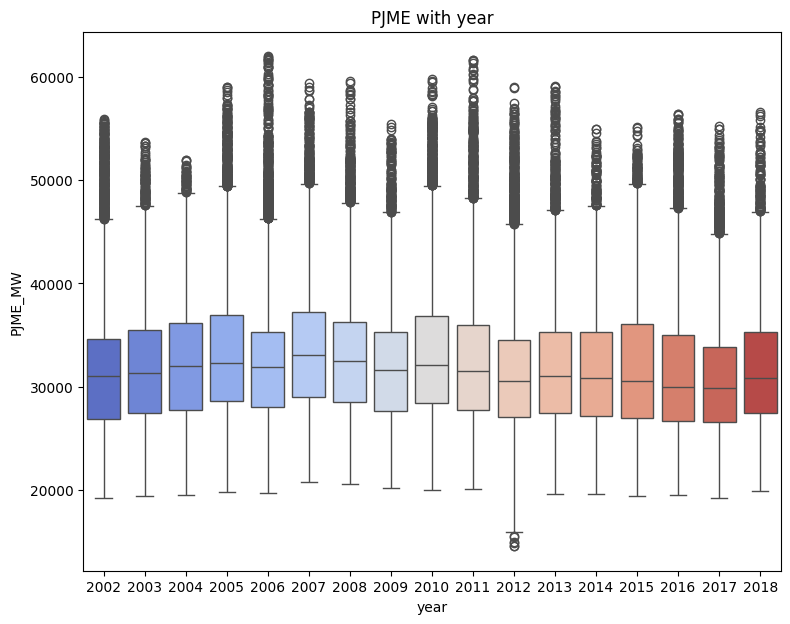

In [46]:
feature = df[['hour','quarter','month','year']]

for i in feature.columns:
  fig, ax = plt.subplots(figsize = (9,7))
  sns.boxplot(data = df, x=i, y='PJME_MW', palette = 'coolwarm')
  ax.set_title(f'PJME with {i}')
  plt.show()

# **Create Model**

In [50]:
# 有关时间序列的 data都要这么写train/test

train = create_features(df_train)
test = create_features(df_test)

FEATURES = ['dayofweek', 'dayofyear', 'hour', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'


X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


<ipython-input-45-fe4eeeadf300>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
<ipython-input-45-fe4eeeadf300>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
<ipython-input-45-fe4eeeadf300>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [74]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

reg = xgb.XGBRegressor(n_estimators=500, objective='reg:squarederror')  # 设置 n_estimators，比如500，使用平方误差损失函数来处理回归任务

reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True) #验证集数据，用于评估模型在训练过程中的表现 verbose=True：显示每轮训练的详细信息。

y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


[0]	validation_0-rmse:5359.38817
[1]	validation_0-rmse:4687.05895
[2]	validation_0-rmse:4279.34116
[3]	validation_0-rmse:4082.65727
[4]	validation_0-rmse:3952.59599
[5]	validation_0-rmse:3881.10969
[6]	validation_0-rmse:3856.18425
[7]	validation_0-rmse:3790.18994
[8]	validation_0-rmse:3790.84531
[9]	validation_0-rmse:3762.80758
[10]	validation_0-rmse:3765.42212
[11]	validation_0-rmse:3759.69957
[12]	validation_0-rmse:3779.90307
[13]	validation_0-rmse:3817.71335
[14]	validation_0-rmse:3808.24388
[15]	validation_0-rmse:3797.68288
[16]	validation_0-rmse:3809.53263
[17]	validation_0-rmse:3853.64558
[18]	validation_0-rmse:3910.79286
[19]	validation_0-rmse:3916.14413
[20]	validation_0-rmse:3919.85215
[21]	validation_0-rmse:3937.15739
[22]	validation_0-rmse:3946.71063
[23]	validation_0-rmse:3945.58168
[24]	validation_0-rmse:3949.76449
[25]	validation_0-rmse:3966.60413
[26]	validation_0-rmse:3976.04858
[27]	validation_0-rmse:3995.40088
[28]	validation_0-rmse:3995.40792
[29]	validation_0-rmse:4

# **Feature Importance**

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

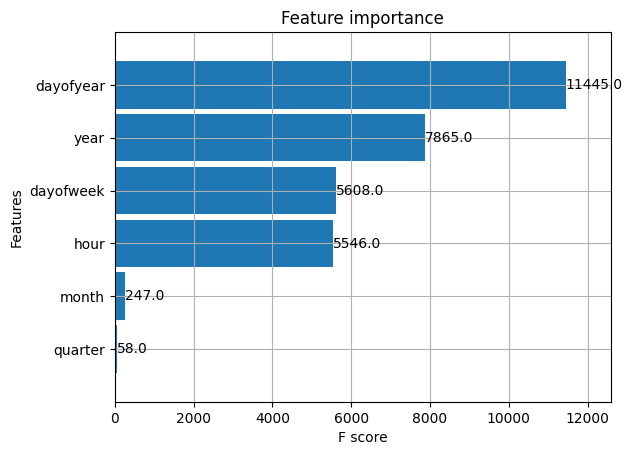

In [76]:
plot_importance(reg, height = 0.9)

# **Forecast on Test Set**

In [79]:
df_test['MW_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train])

<ipython-input-79-875795a992b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['MW_Prediction'] = reg.predict(X_test)


<Axes: xlabel='Datetime'>

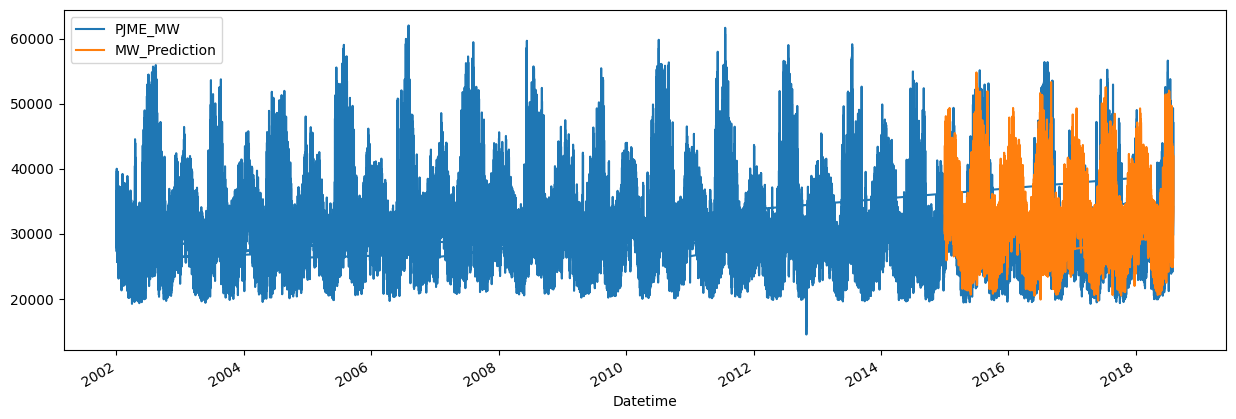

In [82]:
df_all[['PJME_MW','MW_Prediction']].plot(figsize = (15,5))

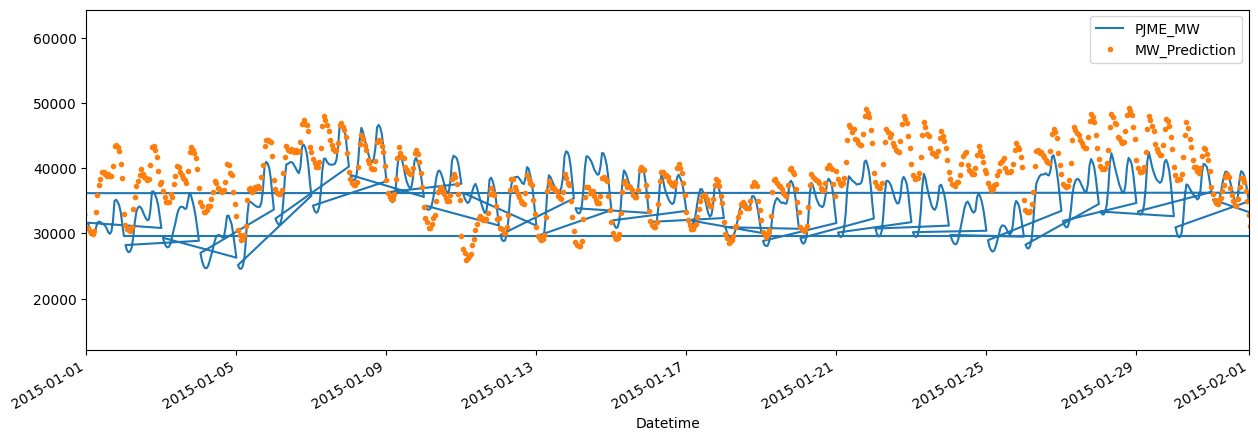

In [91]:
f, ax = plt.subplots(figsize = (15,5))
df_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower = '01-01-2015', upper = '02-01-2015')

Text(0.5, 1.0, 'First Week of January Forecast vs Actuals')

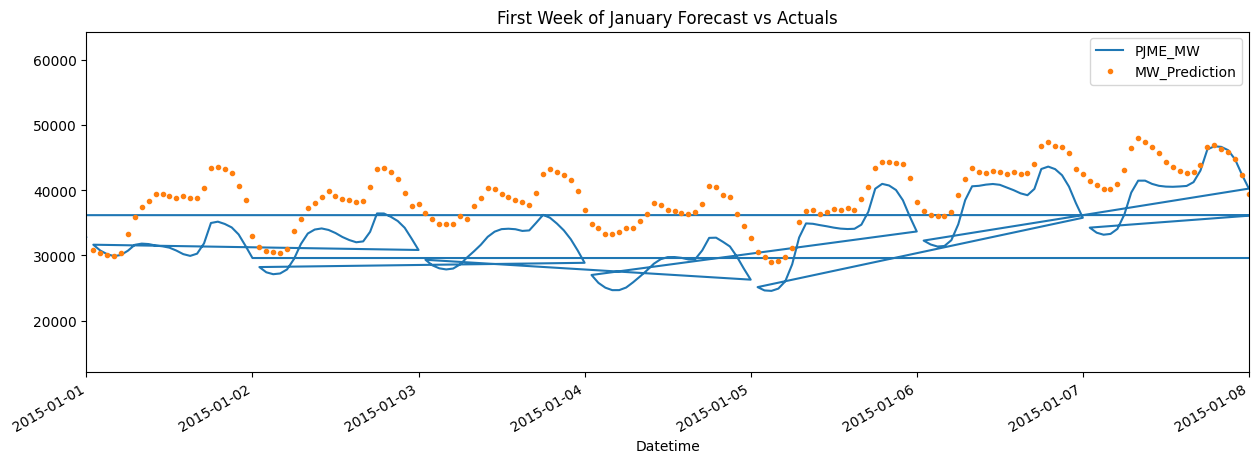

In [98]:
f, ax = plt.subplots(figsize = (15,5))
df_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower = '01-01-2015', upper = '01-08-2015')
plt.title('First Week of January Forecast vs Actuals')

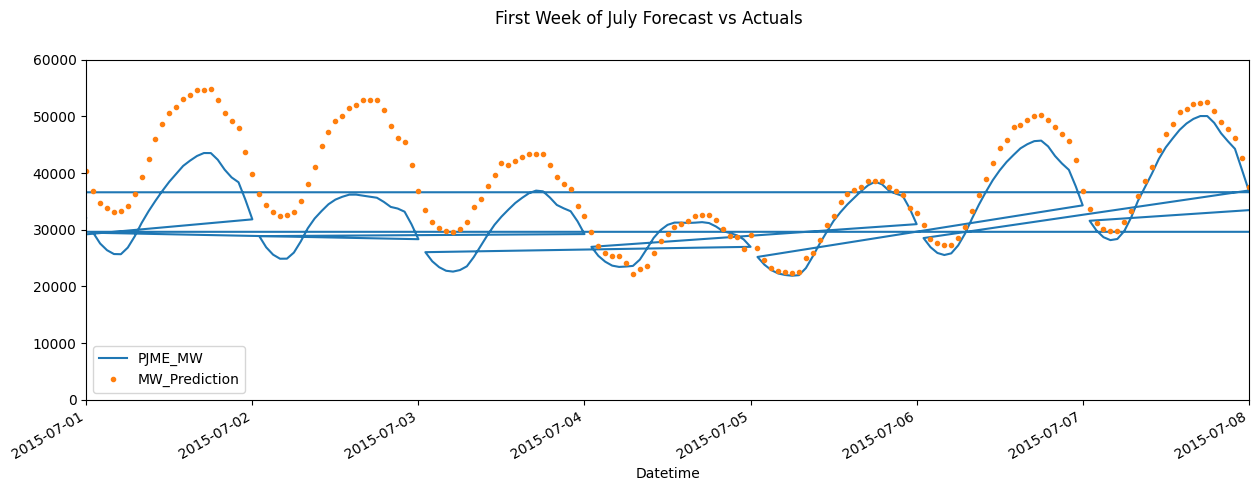

In [103]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['PJME_MW','MW_Prediction']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# **Error Metrics on Test Set**

In [104]:
mean_squared_error(y_true =df_test['PJME_MW'], y_pred= df_test['MW_Prediction'])

23496314.07647124

In [105]:
mean_absolute_error(y_true =df_test['PJME_MW'], y_pred= df_test['MW_Prediction'])

3857.491684231269

In [106]:
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [107]:
mean_absolute_percentage_error(y_true =df_test['PJME_MW'], y_pred= df_test['MW_Prediction'])

12.517643140310202

# **Look at Worst and Best Predicted Days**

In [109]:
df_test['error'] = df_test['PJME_MW'] - df_test['MW_Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)

error_by_date = df_test.groupby(['year','month','dayofmonth']).mean()[['PJME_MW','MW_Prediction','error','abs_error']]
# df_test 数据框按 'year'、'month' 和 'dayofmonth' 列进行分组，然后对每个组计算 'PJME_MW'、'MW_Prediction'、'error' 和 'abs_error' 这些列的均值。

<ipython-input-109-74825a83646f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['error'] = df_test['PJME_MW'] - df_test['MW_Prediction']
<ipython-input-109-74825a83646f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['abs_error'] = df_test['error'].apply(np.abs)


In [113]:
error_by_date.sort_values('error', ascending = True).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2017 9     2           24201.458333   39526.429688 -15324.972331  15324.972331
     1     25          30449.333333   44043.777344 -13594.442383  13594.442383
           26          30215.916667   43749.441406 -13533.523763  13533.523763
     9     1           27280.500000   40093.824219 -12813.322510  12813.322510
     1     4           30889.333333   43363.160156 -12473.826335  12473.826335
2016 1     27          32358.083333   44761.285156 -12403.205566  12403.205566
2017 1     21          28135.125000   40427.472656 -12292.347493  12292.347493
     9     3           24385.625000   36630.652344 -12245.029134  12245.029134
     1     22          27275.250000   39443.453125 -12168.202311  12168.202311
2018 1     24          32071.458333   44043.777344 -11972.317383  11972.317383

In [114]:
error_by_date.sort_values('error', ascending = False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   28612.884766  16572.949219  16572.949219
           14          44427.333333   28605.146484  15822.186361  15822.186361
           12          45724.708333   32909.394531  12815.314860  12815.314860
     9     10          40996.166667   29923.751953  11072.414144  11072.414144
2015 2     20          44694.041667   33697.996094  10996.043701  10996.043701
2016 8     11          45225.458333   34694.277344  10531.182617  10531.182617
2018 1     1           40191.041667   29766.525391  10424.514567  10424.514567
2015 2     21          40918.666667   30839.093750  10079.572673  10079.572673
2016 9     9           43836.958333   34116.613281   9720.346354   9720.346354
2017 5     19          38032.583333   28324.833984   9707.749593   9707.749593

In [116]:
error_by_date.sort_values('abs_error', ascending = True).head(10) #best_day

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2017 4     1           27047.041667   27412.419922 -365.377279  399.521810
2015 9     25          28264.875000   28527.130859 -262.254150  441.683350
2016 10    8           25183.333333   25677.544922 -494.210205  515.051188
2017 3     18          29677.083333   29547.501953  129.581462  567.701090
     6     25          31818.375000   31324.562500  493.813802  581.712077
2018 7     31          34539.083333   34675.796875 -136.714111  584.602946
     3     12          32489.166667   32176.281250  312.884603  588.346517
2016 3     20          27989.416667   28545.726562 -556.309977  598.477295
2017 6     16          32150.416667   31654.718750  495.696859  607.581950
     11    8           29431.916667   29885.789062 -453.871419  611.924479

In [126]:
# Best predicted days
error_by_date.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2017 4     1           27047.041667   27412.419922 -365.377279  399.521810
2015 9     25          28264.875000   28527.130859 -262.254150  441.683350
2016 10    8           25183.333333   25677.544922 -494.210205  515.051188
2017 3     18          29677.083333   29547.501953  129.581462  567.701090
     6     25          31818.375000   31324.562500  493.813802  581.712077
2018 7     31          34539.083333   34675.796875 -136.714111  584.602946
     3     12          32489.166667   32176.281250  312.884603  588.346517
2016 3     20          27989.416667   28545.726562 -556.309977  598.477295
2017 6     16          32150.416667   31654.718750  495.696859  607.581950
     11    8           29431.916667   29885.789062 -453.871419  611.924479

In [117]:
error_by_date.sort_values('abs_error', ascending = False).head(10) #worst_day

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   28612.884766  16572.949219  16572.949219
           14          44427.333333   28605.146484  15822.186361  15822.186361
2017 9     2           24201.458333   39526.429688 -15324.972331  15324.972331
     1     25          30449.333333   44043.777344 -13594.442383  13594.442383
           26          30215.916667   43749.441406 -13533.523763  13533.523763
2016 8     12          45724.708333   32909.394531  12815.314860  12815.314860
2017 9     1           27280.500000   40093.824219 -12813.322510  12813.322510
     1     4           30889.333333   43363.160156 -12473.826335  12473.826335
2016 1     27          32358.083333   44761.285156 -12403.205566  12403.205566
2017 1     21          28135.125000   40427.472656 -12292.347493  12292.347493

# **Plotting some best/worst predicted days**

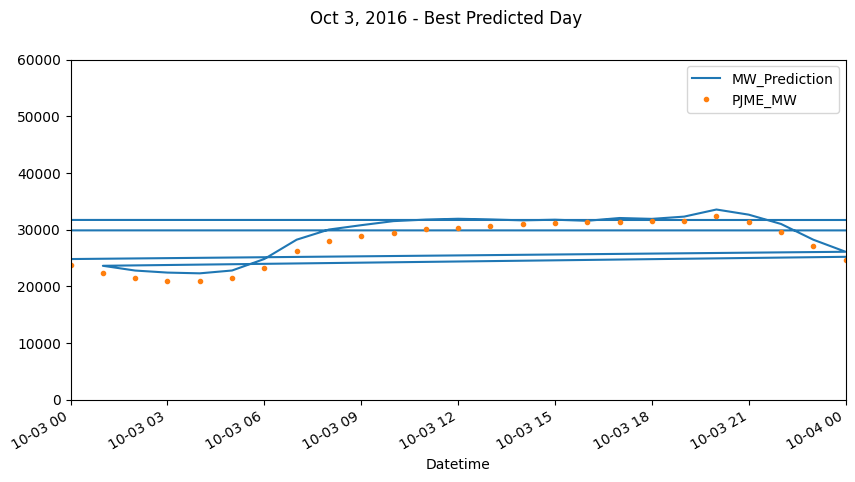

In [122]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

Text(0.5, 1.0, '04 01 2016 Best Predicted Day')

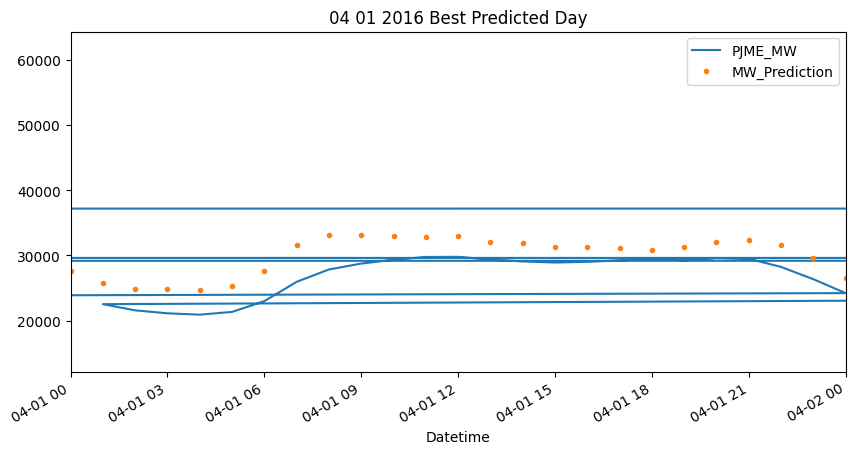

In [124]:
f, ax = plt.subplots(figsize = (10,5))
df_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style = ['-', '.'])

ax.set_xbound(lower='04-01-2016', upper='04-02-2016')
plt.title('04 01 2016 Best Predicted Day')